# Clustering for Pairs Trading 

## Table of Contents
- [1. Loading the Data](#section-1)
  * [1.1 Retrieve S&P500 Constituent Stocks (Latest)](#subsection-11)
  * [1.2 Exclude Stocks Added after December 31, 2020](#subsection-12)
  * [1.3 Retrieve Price Data From Yahoo Finance (2021 - 2023)](#subsection-13)
$$$$
- [2. Data Preparation](#section-2)
  * [2.1 Feature Engineering](#subsection-21)
  * [2.2 Z-score Normalization](#subsection-22)
  * [2.3 Anomaly Detection](#subsection-23)  
$$$$
- [3. K-Means Clustering](#section-3) 
  * [3.1 Finding the Optimal Number of Clusters : Elbow Method](#subsection-31)
  * [3.2 Cluster Visualization](#subsection-32)
$$$$
- [4. Affinity Propagation Clustering](#section-4)
  * [4.1 Finding the Optimal Number of Clusters : Damping](#subsection-42)
  * [4.2 Cluster Visualization](#subsection-42)
$$$$
- [5. Mean Shift Clustering](#section-5)
  * [5.1 Finding the Optimal Number of Clusters : Bandwidth Estimation](#subsection-51)
  * [5.2 Cluster Visualization](#subsection-52)
$$$$
- [6. Hierarchical Agglomerative Clustering](#section-6) 
  * [6.1 Finding the Optimal Number of Clusters : Linkage and Dendogram](#subsection-61)
  * [6.2 Cluster Visualization](#subsection-62)
$$$$
- [7. DBSCAN Clustering](#section-7)
  * [7.1 Finding the Optimal Number of Clusters : Nearest Neighbors Maximum Curvature Method](#subsection-71)
  * [7.2 Cluster Visualization](#subsection-72)
$$$$
- [8. Gaussian Mixture Models Clustering](#section-8)
  * [8.1 Finding the Optimal Number of Clusters : Minimum AIC and BIC](#subsection-81)
  * [8.2 Cluster Visualization](#subsection-82)
$$$$
- [9. BIRCH Clustering](#section-9)
  * [9.1 Finding the Optimal Number of Clusters : Threshold](#subsection-91)
  * [9.2 Cluster Visualization](#subsection-92)
$$$$
- [10. Clustering Performance](#section-10)
  * [10.1 Silhouette Score (>)](#subsection-101)
  * [10.2 Calinski-Harabasz Score (>)](#subsection-102)
  * [10.3 Davies-Bouldin Score (<)](#subsection-103)
$$$$
- [11. Pairs Selection : Engle-Granger Cointegration Test](#section-11)
  * [11.1 Cointegrated Pairs](#subsection-111)
  * [11.2 Pairs Visualization](#subsection-112)
$$$$
- [12. Pairs Selection : Augmented Dickey Fuller Test](#section-12)
  * [12.1 Cointegrated Pairs](#subsection-121)
  * [12.2 Pairs Visualization](#subsection-122)
$$$$
- [13. Pairs Trading](#section-13)

## Objective 

This notebook illustrates how clustering can extract more robust stock pairs for pairs trading. Testing 7 algorithms with different cluster assignment processes, we highlight their strengths and weaknesses in grouping stocks with comparable risk-return profiles. Unique methods to obtain the optimal number of clusters help explain key hyperparameters that influence within-cluster cohesion and between-cluster dispersion. 

## Importing the Necessary Libraries 

In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 
from sklearn import preprocessing, model_selection, cluster, neighbors, ensemble, mixture, metrics, manifold  
from scipy.cluster import hierarchy  
from scipy.stats import f 
from statsmodels.tsa import stattools 
from statsmodels.tsa.vector_ar import vecm 
from statsmodels.regression import linear_model  
rs = np.random.seed(123)
# pd.set_option("display.max_rows", None)  
# pd.set_option("display.max_columns", None)  
import warnings
warnings.filterwarnings("ignore")

In [2]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg") 

## 1. Loading the Data 
<a id="section-1"></a>

### 1.1 Retrieve S&P500 Constituent Stocks (Latest) 
<a id="subsection-11"></a>

In [3]:
wikipedia = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#Selected_changes_to_the_list_of_S&P_500_components")
sp500_constituents = wikipedia[0][["Symbol", "GICS Sector", "Date added"]].copy( )
sp500_constituents["Date added"] = pd.to_datetime(sp500_constituents["Date added"]) 

### 1.2 Exclude Stocks Added after December 31, 2020 
<a id="subsection-12"></a>

In [4]:
sp500_2123 = sp500_constituents.loc[sp500_constituents["Date added"] < pd.to_datetime("2020-12-31")]
sp500_2123 = sp500_2123.loc[ ~ sp500_2123["Symbol"].isin(["BF.B" , "BRK.B"]) ]
tickers_2123 = sp500_2123["Symbol"].tolist( ) 

### 1.3 Retrieve Price Data From Yahoo Finance (2021 - 2023)
<a id="subsection-13"></a>

In [5]:
start_date = "2020-12-31"
end_date = "2024-01-01"
sp500 = yf.download(tickers = tickers_2123,  start = start_date,  end = end_date)

[*********************100%%**********************]  451 of 451 completed


In [6]:
close = sp500["Close"].copy( ) 
returns = close.pct_change(periods = 1).iloc[1 :]
close = close.iloc[1 :]

## 2. Data Preparation 
<a id="section-2"></a>

### 2.1 Feature Engineering
<a id="subsection-21"></a>

$$
\text{Annualized } \bar{\text{Return}} = \frac{1}{T} \left( \sum_{i=t}^{T} \text{Return}_{t} \right) \times 252 
$$ 

$$
\text{Annualized } \sigma = \left( \sqrt{\frac{1}{T}\sum_{i=t}^{T}(\text{Return}_{t} - \bar{\text{Return}})^2} \right) \times \sqrt{252} 
$$ 

$$
\text{Annualized Sharpe Ratio} = \frac{\text{Annualized } \bar{\text{Return}}}{\text{Annualized } \sigma}
$$ 

In [7]:
def risk_return(returns_df) :
    """
    Arguments :
    - returns_df : DataFrame of daily returns 
    
    Returns :
    - summary_df : DataFrame displaying the annualized return and annualized standard deviation
    
    Function :
    - Computes the average daily return and average daily standard deviation
    - Annualizes the average daily return and average daily standard deviation 
    """
    summary_df = returns_df.agg(["mean" , "std"]).transpose( )
    summary_df.columns = ["Return" , "Std"]

    summary_df["Annual Return"] = summary_df["Return"] * 252 
    summary_df["Annual Volatility"] =  summary_df["Std"] * np.sqrt(252)  
    summary_df["Annual Sharpe"] =  summary_df["Annual Return"].div(summary_df["Annual Volatility"])
    
    summary_df.drop(columns = ["Return", "Std"], inplace = True)
    return summary_df   

In [8]:
summary = risk_return(returns)

In [9]:
summary.round(4)

,Annual Return,Annual Volatility,Annual Sharpe
Ticker,,,
A,0.0932,0.2821,0.3302
AAL,0.0639,0.4701,0.1360
AAPL,0.1632,0.2782,0.5867
ABBV,0.1454,0.2085,0.6974
ABT,0.0278,0.2278,0.1218
...,...,...,...
XYL,0.0766,0.2739,0.2796
YUM,0.0816,0.1979,0.4122
ZBH,-0.0366,0.2546,-0.1440


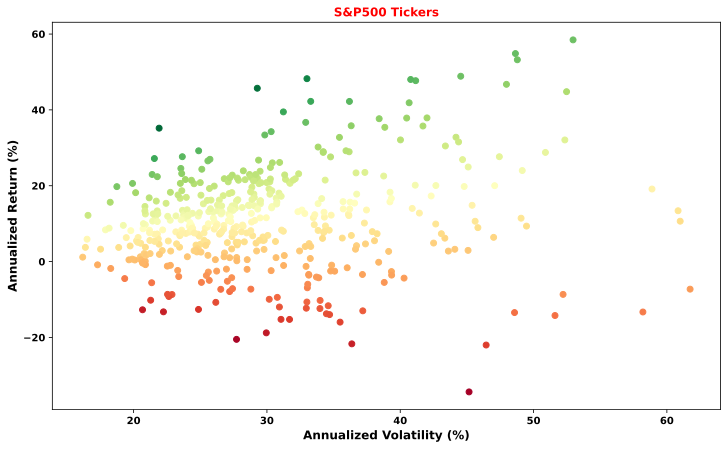

In [10]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100, 
            c = summary["Annual Sharpe"], cmap = "RdYlGn") 

plt.title(label = "S&P500 Tickers", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
# plt.colorbar(label = "Sharpe")
plt.show( )

### 2.2 Z-score Normalization 
<a id="subsection-22"></a>

$$
Z = \frac{{X - \mu}}{{\sigma}}
$$ 

In [11]:
std_scaler = preprocessing.StandardScaler( )
summary_scaled = pd.DataFrame(data = std_scaler.fit_transform(summary), index = summary.index, columns = summary.columns) 

### 2.3. Anomaly Detection
<a id="section-23"></a>

1. **Random Partitioning**
 > The algorithm starts by randomly selecting a feature and then randomly selecting a split value within the range of that feature's values.

2. **Recursive Partitioning**
> It recursively partitions the data into subsets based on random splits until each data point is isolated in its own partition.

3. **Tree Construction**
> This process creates isolation trees, which are binary trees where each internal node represents a split on a feature, and each leaf node represents an isolated data point.

4. **Path Length Calculation**
> - For each data point, the algorithm measures its average path length in the isolation trees.
> - Anomalies are expected to have shorter average path lengths because they are easier to isolate.

5. **Anomaly Score Calculation**
> - The anomaly score for each data point is calculated based on its average path length.
> - Data points with shorter average path lengths (closer to the root) are considered more likely to be anomalies.

6. **Thresholding**
> - A threshold is set to determine which data points are considered outliers based on their anomaly scores.
> - Data points with anomaly scores above the threshold are classified as outliers.

In [12]:
islf = ensemble.IsolationForest(contamination = 0.1, n_jobs = - 1, random_state = rs)
labels = islf.fit_predict(summary) 

In [13]:
anomaly_index = np.where(labels == - 1)[0]
anomaly_summary = summary.iloc[anomaly_index]

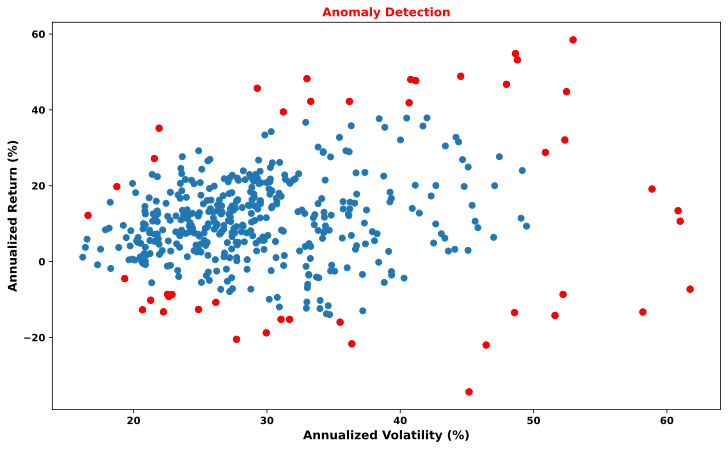

In [14]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100) 
plt.scatter(x = anomaly_summary["Annual Volatility"] * 100, y = anomaly_summary["Annual Return"] * 100, s = 40, c = "red") 

plt.title(label = "Anomaly Detection", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
plt.show( )

## 3. K-Means Clustering ***(Centroid-Based)***
<a id="section-3"></a>

1. **Initialization**
> Randomly select $ \text{\( k \)} $ centroids from the data points, where $ \text{\( k \)} $ is the number of clusters specified by the user.

2. **Assign Points to Nearest Centroid** 
> Assign each data point to the nearest centroid based on Euclidean distance.

3. **Update Centroids**
> Recalculate the centroid of each cluster by taking the mean of all data points assigned to that cluster.

4. **Convergence Criteria** 
> Repeat steps 2 and 3 until convergence. Convergence is achieved when centroids do not change significantly between iterations, or when a maximum number of iterations is reached.

5. **Cluster Assignment**
> After convergence, each data point is assigned to one cluster based on the nearest centroid.

6. **Output**
> The final output of the algorithm is $ \text{\( k \)} $ clusters, where each cluster is represented by its centroid and data points assigned to it.

### 3.1 Finding the Optimal Number of Clusters : Elbow Method
<a id="subsection-31"></a>

$$ \text{Inertia} = \sum_{i=0}^{n} \min_{\mu_j \in C}(||x_i - \mu_j||^2) $$

$\text{Where :}$
- $ n \text{ is the total number of samples.} $
- $ x_{i} \text{ represents each sample.} $
- $ \mu_j \text{ denotes the centroid of the cluster \( C \) to which \( x_i \) is assigned.} $
- $ ||x_i - \mu_j||^2 \text{ calculates the squared Euclidean distance between \( x_i \) and \( \mu_j \).} $

In [15]:
inertia_vals = [ ]
silhouette_vals = [ ]
for k in range(2, 16) :
    
    kmeans_clt = cluster.KMeans(n_clusters = k, init = "k-means++" , n_init = 10, random_state = rs)
    kmeans_clt.fit(summary_scaled) 
    inertia_vals.append(kmeans_clt.inertia_) 
    
    silhouette = metrics.silhouette_score(summary_scaled, kmeans_clt.labels_, metric = "euclidean")
    silhouette_vals.append(silhouette)  
    
inertia_df = pd.DataFrame({"N_Clusters" : range(2, 16), "Inertia" : inertia_vals})

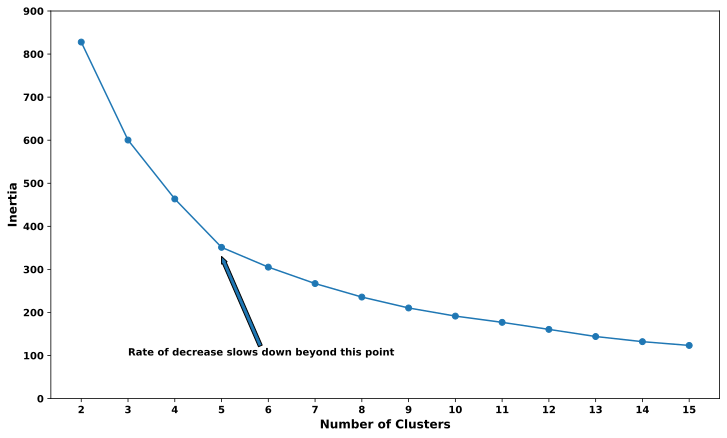

In [16]:
plt.figure(figsize = (12, 7))
plt.plot(inertia_df["N_Clusters"], inertia_df["Inertia"], marker = "o") 
plt.annotate("Rate of decrease slows down beyond this point", 
             xy = (5, 330), xytext = (3, 100), arrowprops = {"width" : 4, "headwidth" : 6, "headlength" : 7}) 

plt.xticks(ticks = range(2, 16)) 
plt.yticks(ticks = range(0, 901, 100)) 
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel(ylabel = "Inertia", fontsize = 12)
plt.style.use("default")
plt.show( )

In [17]:
n_clusters = 5   
kmeans_clt = cluster.KMeans(n_clusters = n_clusters, init = "k-means++" , n_init = 10, random_state = rs)
kmeans_clt.fit(summary_scaled) 

KMeans(n_clusters=5, n_init=10)

In [18]:
kmeans_clt_labels = kmeans_clt.predict(summary_scaled)  
kmeans_clt_df = pd.DataFrame({"Cluster" : kmeans_clt_labels}, index = summary_scaled.index) 
kmeans_centroids = std_scaler.inverse_transform(kmeans_clt.cluster_centers_)

### 3.2 Cluster Visualization 
<a id="subsection-32"></a>

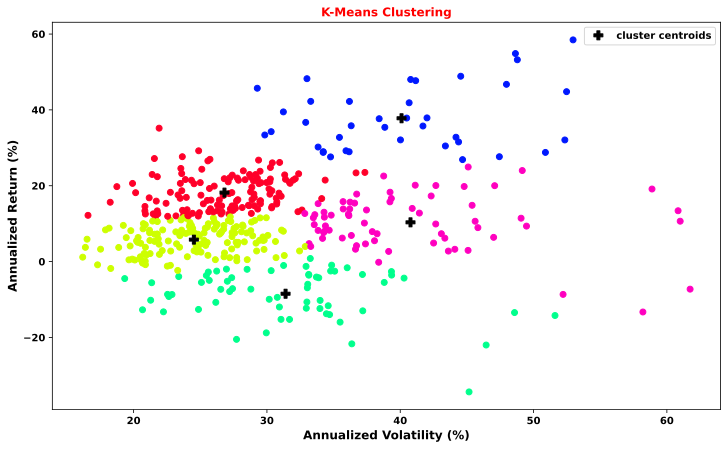

In [19]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"].mul(100), y = summary["Annual Return"].mul(100), 
            c = kmeans_clt_labels, cmap = "gist_rainbow")
plt.plot(kmeans_centroids[: , 1] * 100, kmeans_centroids[: , 0] * 100, "Pk", markersize = 9, label = "cluster centroids")

plt.title(label = "K-Means Clustering", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
plt.legend( )
# plt.colorbar(ticks = range(0, n_clusters), label = "Cluster")
plt.show( ) 

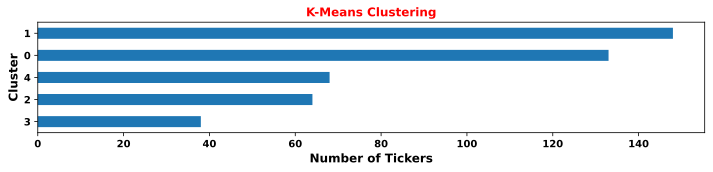

In [20]:
kmeans_clt_df["Cluster"].value_counts(ascending = True).plot(kind = "barh", figsize = (12, int(n_clusters / 2)), fontsize = 10) 
plt.title(label = "K-Means Clustering", c = "red")
plt.xlabel("Number of Tickers", fontsize = 12)
plt.ylabel("Cluster", fontsize = 12)
plt.show( )

## 4. Affinity Propagation Clustering ***(Centroid-Based)***
<a id="section-4"></a>

1. **Similarity Matrix Calculation**
> The similarity matrix represents the similarity between pairs of data points based on a distance measure (negative squared Euclidean).

2. **Preference Initialization**
> Assign each data point a preference value, which indicates the initial level of attractiveness for a data point to become an exemplar. Preference can be set manually or computed from the similarity matrix.

3. **Message Passing**
> Iteratively update two messages for each data point :
> - **Responsibility (r)**: Represents the suitability of one data point being the exemplar for another data point.
> - **Availability (a)**: Indicates the suitability of a data point choosing another data point as its exemplar.

4. **Exemplar Selection**
> At each iteration, data points evaluate their total suitability as exemplars based on the received messages (responsibility and availability). The data point with the highest total suitability becomes the exemplar.

5. **Cluster Formation**
> Assign each data point to the exemplar with the highest total suitability.

6. **Convergence Criteria**
> Repeat steps 3-5 until convergence criteria are met. Convergence may be reached when the assignments of data points to exemplars no longer change significantly between iterations, or when a maximum number of iterations is reached.

7. **Output**
> The final output of the algorithm is the clusters formed, where each cluster is represented by its exemplar and data points assigned to it. 

### 4.1 Finding the Optimal Number of Clusters 
<a id="subsection-41"></a>

In [21]:
ap_clt = cluster.AffinityPropagation(damping = 0.85, max_iter = 200, affinity = "euclidean", verbose = True, random_state = rs)
ap_clt.fit(summary_scaled) 

Converged after 47 iterations.


AffinityPropagation(damping=0.85, verbose=True)

In [22]:
ap_clt_labels = ap_clt.predict(summary_scaled)  
ap_clt_df = pd.DataFrame({"Cluster" : ap_clt_labels}, index = summary_scaled.index) 
ap_centroids = std_scaler.inverse_transform(ap_clt.cluster_centers_)

In [23]:
n_clusters = len(np.unique(ap_clt_labels))

### 4.2 Cluster Visualization 
<a id="subsection-42"></a>

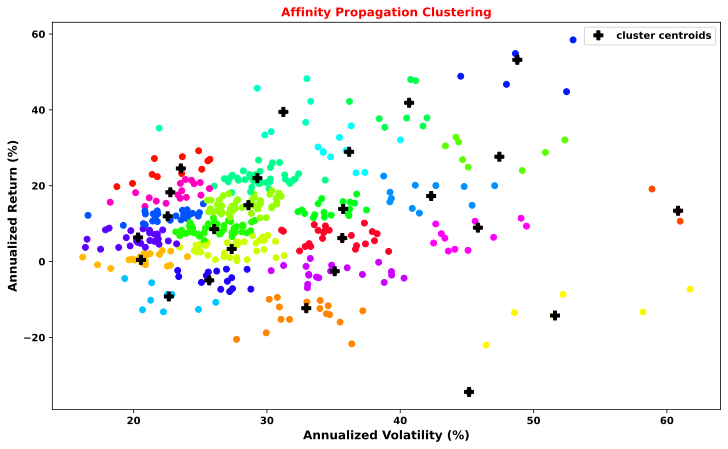

In [24]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100, 
            c = ap_clt_labels, cmap = "gist_rainbow")
plt.plot(ap_centroids[: , 1] * 100, ap_centroids[: , 0] * 100, "Pk", markersize = 9, label = "cluster centroids")

plt.title(label = "Affinity Propagation Clustering", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
plt.legend( )
# plt.colorbar(ticks = range(0, n_clusters, 2), label = "Cluster")
plt.show( ) 

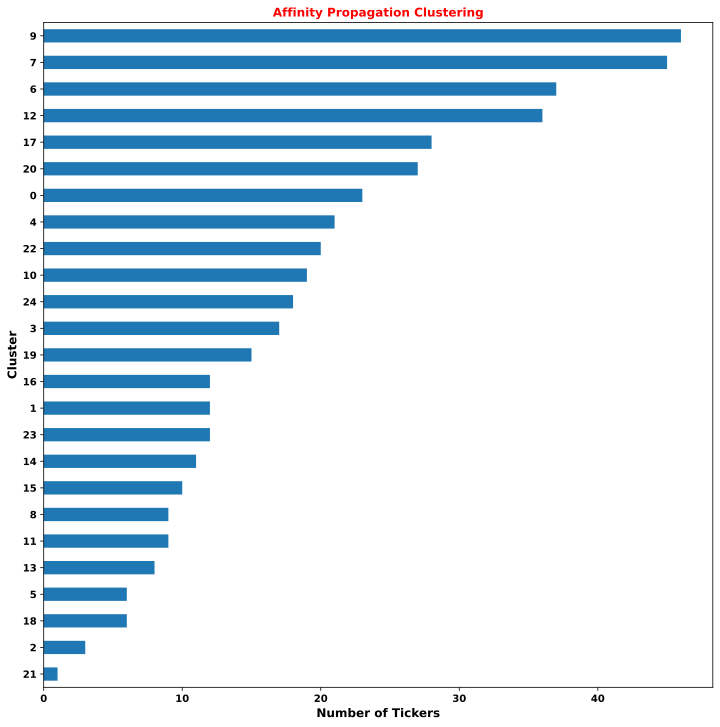

In [25]:
ap_clt_df["Cluster"].value_counts(ascending = True).plot(kind = "barh", figsize = (12, int(n_clusters / 2)), fontsize = 10) 
plt.title(label = "Affinity Propagation Clustering", c = "red")
plt.xlabel("Number of Tickers", fontsize = 12)
plt.ylabel("Cluster", fontsize = 12)
plt.show( ) 

## 5. Mean Shift Clustering ***(Centroid-Based)***
<a id="section-5"></a>

1. **Bandwidth Selection**
> Specify the size of the window around a data point, also known as its neighborhood. Points within the window are considered neighbors. 

2. **Initialization**
> Start by selecting a random point as the initial cluster centroid. 

3. **Local Density Point Calculation**
> Compute the weighted mean of points in the neighborhood. 

4. **Centroid Update**
> Set the local density point as the new centroid. Compute the window of the new centroid. Neighborhood will contain new points. 

5. **Convergence Criteria** 
> Repeat steps 2, 3, and 4 until the centroid and its window does not update anymore. Local density maximum has been reached. This is considered the "densest point". Repeat step 5 for each remaining data point. 

6. **Cluster Assignment**
> Data points that converge towards the same local density maximum belong to the same cluster.

7. **Output**
> The final output of the algorithm is the clusters formed, where each cluster is represented by its mode and data points assigned to it.

### 5.1 Finding the Optimal Number of Clusters : Bandwidth Estimation 
<a id="subsection-51"></a>

In [26]:
bandwidth = cluster.estimate_bandwidth(summary_scaled, quantile = 0.04, n_jobs = -1, random_state = rs)
mnsft_clt = cluster.MeanShift(bandwidth = bandwidth, n_jobs = - 1)
mnsft_clt.fit(summary_scaled) 

MeanShift(bandwidth=0.5712318126982492, n_jobs=-1)

In [27]:
mnsft_clt_labels = mnsft_clt.predict(summary_scaled)  
mnsft_clt_df = pd.DataFrame({"Cluster" : mnsft_clt_labels}, index = summary_scaled.index) 
mnsft_centroids = std_scaler.inverse_transform(mnsft_clt.cluster_centers_)  

In [28]:
n_clusters = len(np.unique(mnsft_clt_labels))

### 5.2 Cluster Visualization 
<a id="subsection-52"></a>

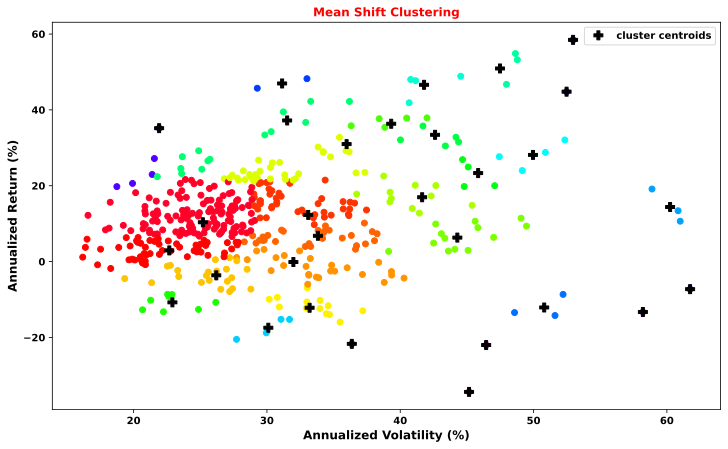

In [29]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100, 
            c = mnsft_clt_labels, cmap = "gist_rainbow")
plt.plot(mnsft_centroids[: , 1] * 100, mnsft_centroids[: , 0] * 100, "Pk", markersize = 9, label = "cluster centroids")

plt.title(label = "Mean Shift Clustering", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
plt.legend( )
# plt.colorbar(ticks = range(0, n_clusters, 2), label = "Cluster")
plt.show( ) 

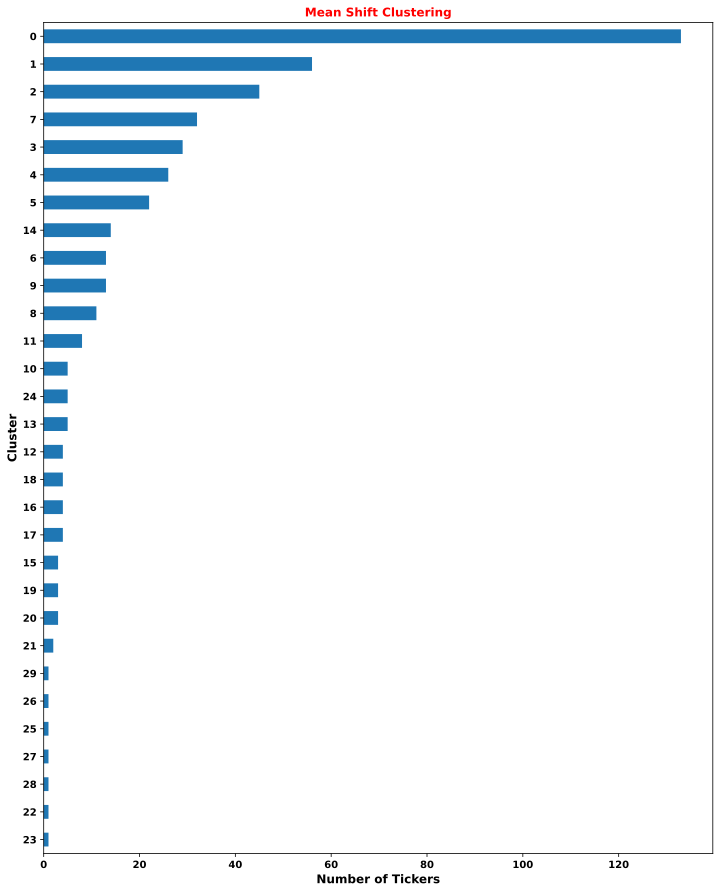

In [30]:
mnsft_clt_df["Cluster"].value_counts(ascending = True).plot(kind = "barh", figsize = (12, int(n_clusters / 2)), fontsize = 10) 
plt.title(label = "Mean Shift Clustering", c = "red")
plt.xlabel("Number of Tickers", fontsize = 12)
plt.ylabel("Cluster", fontsize = 12)
plt.show( ) 

## 6. Hierarchical Agglomerative Clustering ***(Connectivity-Based)***
<a id="section-6"></a>

1. **Initialization**
> Start by considering each data point as a separate cluster.

2. **Pairwise Distance Calculation**
> Compute the pairwise distance (or dissimilarity) between each pair of clusters. This can be done using various distance metrics such as Euclidean distance, Manhattan distance, or cosine distance.

3. **Merge Clusters**
> Identify the two closest clusters based on the computed pairwise distances and merge them into a single cluster. This step is repeated iteratively until only a single cluster remains.

4. **Dendrogram Construction**
> Construct a dendrogram to visualize the hierarchical clustering process. The dendrogram shows the order in which clusters are merged and the distance at which each merge occurs.

5. **Cluster Assignment**
> Decide the number of clusters by cutting the dendrogram at a desired distance threshold. Each branch of the dendrogram below the cut represents a cluster.

6. **Output**
> The final output of the algorithm is the clusters formed at the chosen cut-off level of the dendrogram, and data points assigned to it.

### 6.1 Finding the Optimal Number of Clusters : Linkage and Dendogram
<a id="subsection-61"></a>

In [31]:
linkage = hierarchy.linkage(summary_scaled, method = "ward")

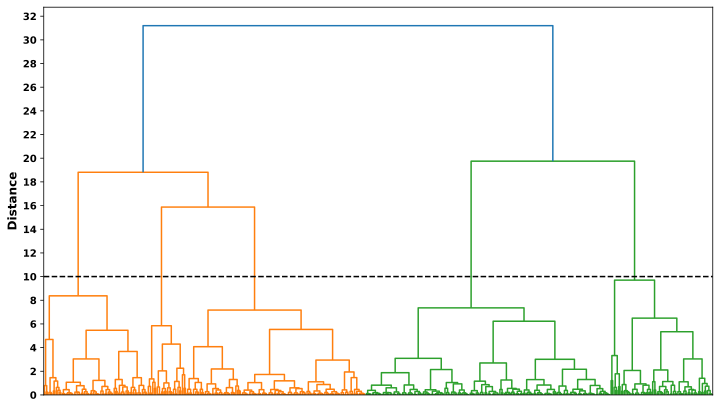

In [32]:
plt.figure(figsize = (12, 7))
hierarchy.dendrogram(linkage, no_labels = True)
plt.axhline(y = 10, linestyle = "--", c = "black")

plt.yticks(ticks = range(0, 33, 2))
plt.ylabel(ylabel = "Distance", fontsize = 12)
plt.show( )

In [33]:
distance = 10
clusters = hierarchy.fcluster(linkage, distance, criterion = "distance")

In [34]:
n_clusters = len(np.unique(clusters)) 
hagg_clt = cluster.AgglomerativeClustering(n_clusters = n_clusters, linkage = "ward", metric = "euclidean") 

In [35]:
hagg_clt_labels = hagg_clt.fit_predict(summary_scaled) 
hagg_clt_df = pd.DataFrame({"Cluster" : hagg_clt_labels}, index = summary_scaled.index) 

### 6.2 Cluster Visualization 
<a id="subsection-62"></a>

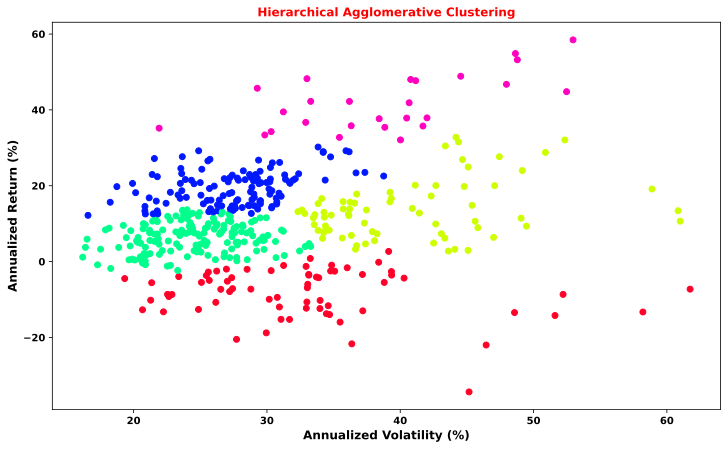

In [36]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100, 
            c = hagg_clt_labels, cmap = "gist_rainbow")

plt.title(label = "Hierarchical Agglomerative Clustering", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
# plt.colorbar(ticks = range(0, n_clusters), label = "Cluster")
plt.show( ) 

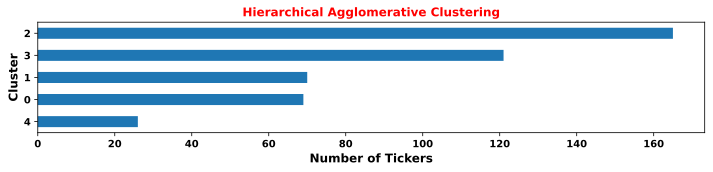

In [37]:
hagg_clt_df["Cluster"].value_counts(ascending = True).plot(kind = "barh", figsize = (12, int(n_clusters / 2)), fontsize = 10) 
plt.title(label = "Hierarchical Agglomerative Clustering", c = "red")
plt.xlabel("Number of Tickers", fontsize = 12)
plt.ylabel("Cluster", fontsize = 12)
plt.show( ) 

## 7. DBSCAN Clustering ***(Density-Based)***
<a id="section-7"></a>

1. **Parameter Initialization**
> Set the two key parameters for DBSCAN :
> - **Epsilon ($\varepsilon$)**: The maximum distance between two samples for them to be considered as in the same neighborhood.
> - **MinPts**: The minimum number of samples in a neighborhood for a data point to be considered as a core point.

2. **Core Point Identification**
> A core point is a data point that has at least MinPts data points (including itself) within its $\varepsilon$ -neighborhood.

3. **Cluster Expansion**
> Expand clusters from core points. For each core point :
> - Form a new cluster if it has not been assigned to any cluster yet.
> - Recursively add all reachable points (density-reachable) to the cluster if they are core points themselves.

4. **Noise Identification**
> Identify noise points, which are data points that are not core points and are not density-reachable from any core points.

5. **Output**
> The final output of the algorithm is the clusters formed, where each cluster contains all data points that are density-connected. Additionally, noise points may be labeled separately or discarded depending on the application.

### 7.1 Finding the Optimal Number of Clusters : Nearest Neighbors Maximum Curvature Method 
<a id="subsection-71"></a>

In [38]:
nn = neighbors.NearestNeighbors(n_neighbors = 2)
nn.fit(summary_scaled)

NearestNeighbors(n_neighbors=2)

In [39]:
distances, indices = nn.kneighbors(summary_scaled) 
distances = np.sort(distances, axis = 0)[: , 1]

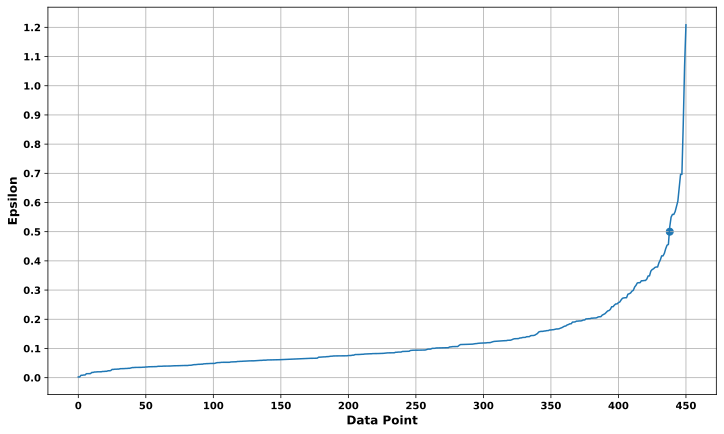

In [40]:
plt.figure(figsize = (12, 7))
plt.plot(distances)  
plt.scatter(438, 0.5, s = 50)

plt.xticks(ticks = range(0, 451, 50))
plt.yticks(ticks = np.array(range(0, 121, 10)) / 100)
plt.xlabel(xlabel = "Data Point", fontsize = 12)
plt.ylabel(ylabel = "Epsilon", fontsize = 12)
plt.grid( )
plt.show( ) 

In [41]:
dbscan_clt = cluster.DBSCAN(eps = 0.5, min_samples = 3, metric = "euclidean", n_jobs = - 1) 

In [42]:
dbscan_clt_labels = dbscan_clt.fit_predict(summary_scaled)  
dbscan_clt_df = pd.DataFrame({"Cluster" : dbscan_clt_labels}, index = summary_scaled.index) 

In [43]:
n_clusters = len(np.unique(dbscan_clt_labels)) 

### 7.2 Cluster Visualization 
<a id="subsection-72"></a>

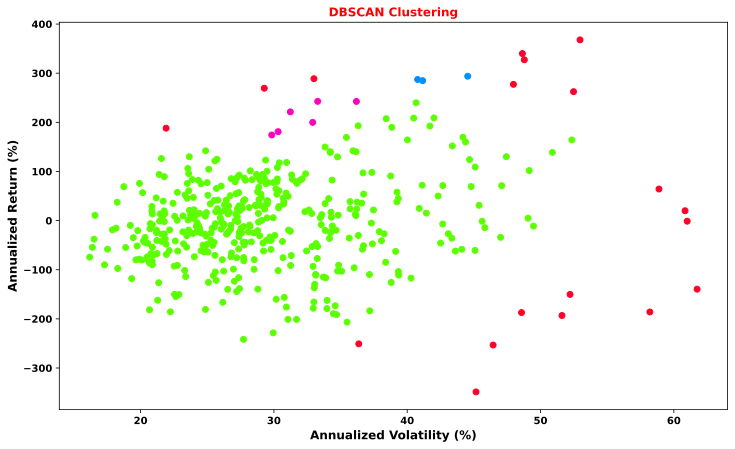

In [44]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary_scaled["Annual Return"] * 100, 
            c = dbscan_clt_labels, cmap = "gist_rainbow")

plt.title(label = "DBSCAN Clustering", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
# plt.colorbar(ticks = range(-1, n_clusters), label = "Cluster")
plt.show( ) 

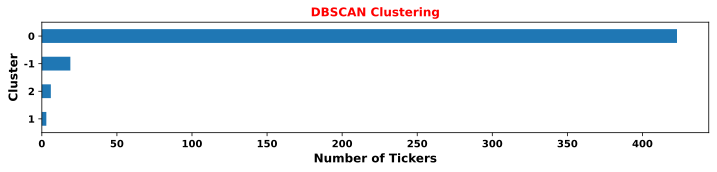

In [45]:
dbscan_clt_df["Cluster"].value_counts(ascending = True).plot(kind = "barh", figsize = (12, int(n_clusters / 2)), fontsize = 10) 
plt.title(label = "DBSCAN Clustering", c = "red")
plt.xlabel("Number of Tickers", fontsize = 12)
plt.ylabel("Cluster", fontsize = 12)
plt.show( ) 

## 8. Gaussian Mixture Models Clustering ***(Distribution-Based)*** 
<a id="section-8"></a>

1. **Initialization**
> - Specify the number of clusters $ \text{\( k \)} $ that you want the model to identify.
> - Initialize the parameters of the $ \text{\( k \)} $ Gaussian distributions : mean, covariance matrix, and mixing coefficients (weights) for each cluster.

2. **Expectation-Maximization (EM)** 
> - **Expectation**
>> - Compute the probability that each data point belongs to each cluster using current parameter estimates. This is done using Bayes' theorem and the probability density function of multivariate Gaussian distributions.
>> - Update the `responsibility` matrix, which stores these probabilities.
> - **Maximization**
>> - Update the parameters of each Gaussian distribution using the current responsibilities.
>> - The mean is updated as the weighted average of data points, where the weights are the responsibilities. 
>> - The covariance matrix is updated using the weighted sum of the outer products of data points minus the updated mean, weighted by responsibilities. 
>> - The mixing coefficient is updated as the mean responsibility of data points assigned to each cluster.

3. **Convergence Criteria** 
> Convergence may be reached when the change in log-likelihood or the change in parameters between iterations falls below a specified threshold, or when a maximum number of iterations is reached. Otherwise, the algorithm continues to the next iteration.

4. **Cluster Assignment**
> After convergence, each data point is assigned to the cluster with the highest probability (i.e., the cluster with the highest responsibility). 

5. **Final Output**
> The final output of the algorithm is the $ \text{\( k \)} $ clusters formed, where each cluster is represented by its centroid and data points assigned to it. 

### 8.1 Finding the Optimal Number of Clusters : Minimum AIC and BIC
<a id="subsection-81"></a>

In [46]:
aic_list = [  ]
bic_list = [  ]
for n_clusters in range(2, 26) :
    
    gmm_clt = mixture.GaussianMixture(n_components = n_clusters, covariance_type = "full", random_state = rs)
    gmm_clt.fit(summary_scaled)     
    
    aic = gmm_clt.aic(summary_scaled)
    bic = gmm_clt.bic(summary_scaled)
    aic_list.append(aic)
    bic_list.append(bic)
    
inf_criterion_df = pd.DataFrame({"N_Clusters" : range(2, 26), "AIC" : aic_list, "BIC" : bic_list})

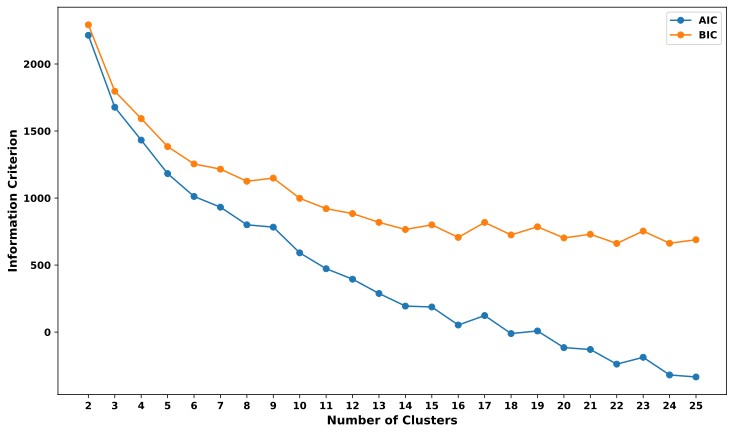

In [47]:
plt.figure(figsize = (12, 7))
plt.plot(inf_criterion_df["N_Clusters"], inf_criterion_df[["AIC", "BIC"]], marker = "o", label = ["AIC", "BIC"]) 

plt.xticks(ticks = range(2, 26)) 
plt.xlabel("Number of Clusters", fontsize = 12)
plt.ylabel(ylabel = "Information Criterion", fontsize = 12)
plt.legend( )
plt.style.use("default")
plt.show( )

In [48]:
n_clusters = 24 
gmm_clt = mixture.GaussianMixture(n_components = n_clusters, covariance_type = "full", random_state = rs)
gmm_clt.fit(summary_scaled) 

GaussianMixture(n_components=24)

In [49]:
gmm_clt_labels = gmm_clt.predict(summary_scaled)  
gmm_clt_df = pd.DataFrame({"Cluster" : gmm_clt_labels}, index = summary_scaled.index) 
gmm_centroids = std_scaler.inverse_transform(gmm_clt.means_) 

### 8.2 Cluster Visualization 
<a id="subsection-82"></a>

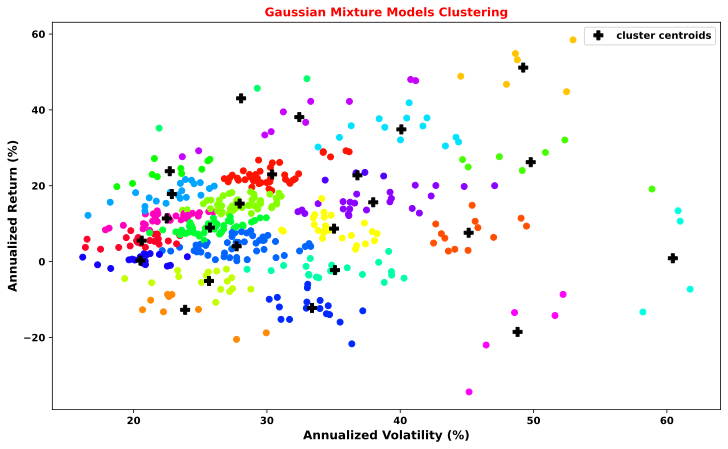

In [50]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100, 
            c = gmm_clt_labels, cmap = "gist_rainbow")
plt.plot(gmm_centroids[: , 1] * 100, gmm_centroids[: , 0] * 100, "Pk", markersize = 9, label = "cluster centroids")

plt.title(label = "Gaussian Mixture Models Clustering", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
plt.legend( )
# plt.colorbar(ticks = range(0, n_clusters, 2), label = "Cluster")
plt.show( )

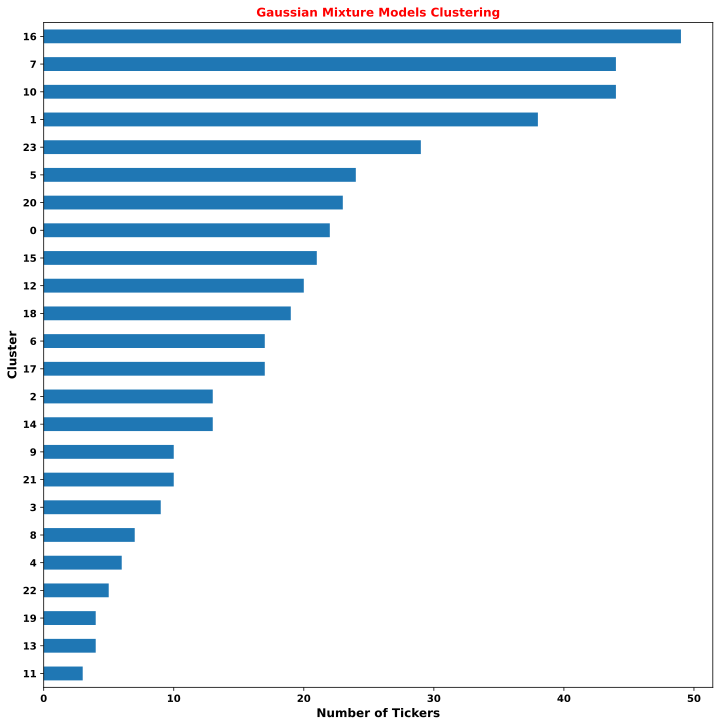

In [51]:
gmm_clt_df["Cluster"].value_counts(ascending = True).plot(kind = "barh", figsize = (12, int(n_clusters / 2)), fontsize = 10) 
plt.title(label = "Gaussian Mixture Models Clustering", c = "red")
plt.xlabel("Number of Tickers", fontsize = 12)
plt.ylabel("Cluster", fontsize = 12)
plt.show( )

## 9. BIRCH Clustering ***(Compression-Based)*** 
<a id="section-9"></a>

1. **Initialization**
> - Start with an empty Cluster Feature Tree.
> - Specify `branching factor` : the maximum number of subclusters in a CF Tree node. 
> - Specify `threshold` : the maximum radius of a subcluster.

2. **Insertion**
> - Insert data points one by one into the CF Tree.
> - At each insertion :
>> - Identify the leaf node in the CF Tree, and the subcluster within that node, that is closest to the new data point based on some distance measure (Euclidean distance).
>> - If the closest subcluster's radius does not exceed `threshold` after insertion, add the data point. Otherwise, create a new subcluster for the data point.
>> - If the number of subclusters in the leaf node exceeds `branching factor` after insertion, split the leaf node into 2 sub-nodes using mini-batch K-means. Subclusters are redistributed in each. 
> - As data points are inserted and leaf nodes are split, the CF Tree grows and organizes the data into a hierarchical structure. Subclusters at higher levels in the CF Tree represent larger, more general clusters. Subclusters at lower levels represent smaller, more specific clusters.

3. **Cluster Assignment**
> Subclusters in the final leaf nodes are considered clusters. 

4. **Final Output**
> The final output of the algorithm is the clusters formed, where each cluster is represented by its centroid and data points assigned to it. 

### 9.1 Finding the Optimal Number of Clusters : Threshold 
<a id="subsection-91"></a>

In [52]:
birch_clt = cluster.Birch(n_clusters = None, branching_factor = 50, threshold = 0.2)
birch_clt.fit(summary)

Birch(n_clusters=None, threshold=0.2)

In [53]:
birch_clt_labels = birch_clt.predict(summary)  
birch_clt_df = pd.DataFrame({"Cluster" : birch_clt_labels}, index = summary.index) 
birch_centroids = birch_clt.subcluster_centers_

In [54]:
n_clusters = len(np.unique(birch_clt_labels)) 

### 9.2 Cluster Visualization 
<a id="subsection-92"></a>

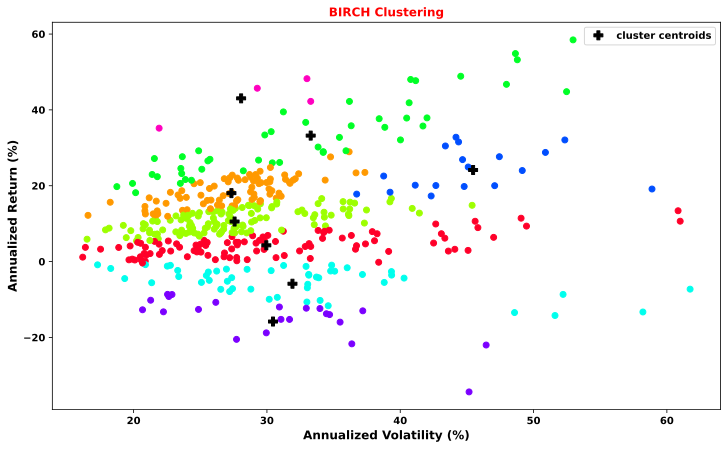

In [55]:
plt.figure(figsize = (12, 7))
plt.scatter(x = summary["Annual Volatility"] * 100, y = summary["Annual Return"] * 100, 
            c = birch_clt_labels, cmap = "gist_rainbow")
plt.plot(birch_centroids[: , 1] * 100, birch_centroids[: , 0] * 100, "Pk", markersize = 9, label = "cluster centroids")

plt.title(label = "BIRCH Clustering", c = "red")
plt.xlabel(xlabel = "Annualized Volatility (%)", fontsize = 12)
plt.ylabel(ylabel = "Annualized Return (%)", fontsize = 12)
plt.legend( )
# plt.colorbar(label = "Cluster")
plt.show( )

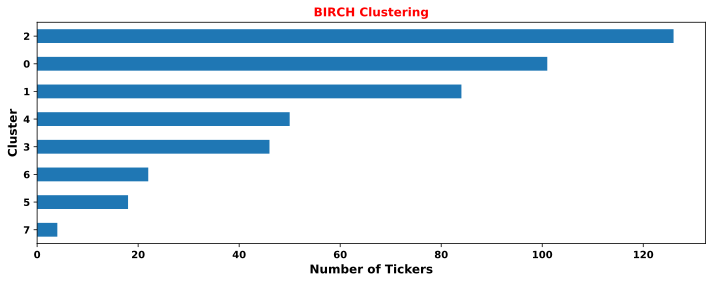

In [56]:
birch_clt_df["Cluster"].value_counts(ascending = True).plot(kind = "barh", figsize = (12, int(n_clusters / 2)), fontsize = 10) 
plt.title(label = "BIRCH Clustering", c = "red")
plt.xlabel("Number of Tickers", fontsize = 12)
plt.ylabel("Cluster", fontsize = 12)
plt.show( )

## 10. Clustering Performance 
<a id="section-10"></a>

### Optimal Outcome :
- Maximize *between-cluster* variation
- Minimize *within-cluster* variation 

In [57]:
clt_labels_dict = {"K-Means" : kmeans_clt_labels , 
                   "Affinity Propagation" : ap_clt_labels, 
                   "Mean Shift" : mnsft_clt_labels, 
                   "Hierarchical Agglomerative" : hagg_clt_labels , 
                   "DBSCAN" : dbscan_clt_labels, 
                   "Gaussian Mixture Models" : gmm_clt_labels, 
                   "BIRCH" : birch_clt_labels} 

### 10.1 Silhouette Score (>)
<a id="subsection-101"></a>

$$
S_i = \frac{b_i - a_i}{\max\{a_i, b_i\}}
$$

$\text{Where :}$
- $ a_i \text{ is the average distance from sample \(i\) to other points in the same cluster.} $
- $ b_i \text{ is the smallest average distance from sample \(i\) to points in a different cluster.} $

In [58]:
silh_scores = { }
for model_name in clt_labels_dict.keys( ) :
    if model_name != "BIRCH" :
        silh_scores[model_name] = metrics.silhouette_score(summary_scaled, clt_labels_dict[model_name], metric = "euclidean")
    else :
        silh_scores[model_name] = metrics.silhouette_score(summary, clt_labels_dict[model_name], metric = "euclidean")
silhouette_scores = pd.DataFrame(silh_scores, index = ["Silhouette Score"]).T 

In [59]:
silhouette_scores.style\
                 .format("{:.4f}")\
                 .highlight_max(color = "lightgreen")\
                 .highlight_min(color = "lightcoral")

,Silhouette Score
K-Means,0.3732
Affinity Propagation,0.3896
Mean Shift,0.2550
Hierarchical Agglomerative,0.3674
DBSCAN,0.3255
Gaussian Mixture Models,0.3280
BIRCH,0.3708


### 10.2 Calinski-Harabasz Score (>) 
<a id="subsection-102"></a>

$$
CH = \frac{tr(B_k)}{tr(W_k)} \times \frac{N - k}{k - 1}
$$

$\text{Where :}$
- $ B_k \text{ is the between-cluster dispersion.} $
- $ W_k \text{ is the within-cluster dispersion.} $
- $ N \text{ is the total number of samples.} $
- $ k \text{ is the number of clusters.} $

In [60]:
ch_scores = { }
for model_name in clt_labels_dict.keys( ) :
    if model_name != "BIRCH" :
        ch_scores[model_name] = metrics.calinski_harabasz_score(summary_scaled, clt_labels_dict[model_name])
    else :
        ch_scores[model_name] = metrics.calinski_harabasz_score(summary, clt_labels_dict[model_name])
    
ch_scores = pd.DataFrame(ch_scores, index = ["Calinski-Harabasz Score"]).T 

In [61]:
ch_scores.style\
         .format("{:.4f}")\
         .highlight_max(color = "lightgreen")\
         .highlight_min(color = "lightcoral")

,Calinski-Harabasz Score
K-Means,318.0480
Affinity Propagation,364.5222
Mean Shift,151.1931
Hierarchical Agglomerative,298.2202
DBSCAN,26.4248
Gaussian Mixture Models,277.2484
BIRCH,656.9048


### 10.3 Davies-Bouldin Score (<) 
<a id="subsection-103"></a>

$$
DB = \frac{1}{n}\sum_{i=1}^{n}\max_{i \neq j} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$

$\text{Where :}$
- $ n \text{ is the number of clusters.} $
- $ c_i \text{ is the centroid of cluster \(i\).} $
- $ \sigma_i \text{ is the average distance between points in cluster \(i\) and its centroid.} $
- $ d(c_i, c_j) \text{ is the distance between centroids \(c_i\) and \(c_j\).} $ 

In [62]:
db_scores = { }
for model_name in clt_labels_dict.keys( ) :
    if model_name != "BIRCH" :
        db_scores[model_name] = metrics.davies_bouldin_score(summary_scaled, clt_labels_dict[model_name])
    else :
        db_scores[model_name] = metrics.davies_bouldin_score(summary, clt_labels_dict[model_name])
    
db_scores = pd.DataFrame(db_scores, index = ["Davies-Bouldin Score"]).T 

In [63]:
db_scores.style\
         .format("{:.4f}")\
         .highlight_max(color = "lightcoral")\
         .highlight_min(color = "lightgreen")

,Davies-Bouldin Score
K-Means,0.8131
Affinity Propagation,0.7042
Mean Shift,0.7104
Hierarchical Agglomerative,0.8123
DBSCAN,1.4664
Gaussian Mixture Models,0.8472
BIRCH,0.7858


## 11. Pairs Selection : Engle-Granger Cointegration Test 
<a id="section-11"></a>

1. **Estimation of the cointegrating regression**

    $ \Delta y_t = \alpha + \beta x_t + \varepsilon_t $

    $ \text{Where :}$
    - $ \Delta \text{ represents the differencing operator.} $
    - $ y_t \text{ and } x_t \text{ are the two time series.} $
    - $ \alpha \text{ is a constant.} $ 
    - $ \beta \text{ is the coefficient on the variable \(x_t\).} $
    - $ \varepsilon_t \text{ is the error term.} $ 

2. **Unit root test on the residuals**
    
    $ \text{Use a unit root test (e.g., ADF test) on the residuals } \varepsilon_t \text{ to check for stationarity.} $

In [64]:
ap_clt_counts = ap_clt_df["Cluster"].value_counts( )
ap_clt_labels = ap_clt_df.copy( )

print (f"Clusters formed : {len(ap_clt_counts)}") 
print (f"Pairs to evaluate : {(ap_clt_counts * (ap_clt_counts - 1)).sum( )}") 

Clusters formed : 25
Pairs to evaluate : 11398


In [65]:
pd.DataFrame(ap_clt_counts)

,count
Cluster,
9,46
7,45
6,37
12,36
17,28
20,27
0,23
4,21
22,20


In [66]:
ap_clt_labels 

,Cluster
Ticker,
A,9
AAL,23
AAPL,7
ABBV,24
ABT,4
...,...
XYL,9
YUM,20
ZBH,19


### 11.1 Cointegrated Pairs  
<a id="subsection-111"></a>

In [67]:
def EG_clt_pairs(clt_close_df, significance = 0.01) : 
    """
    Arguments :
    - clt_close_df : DataFrame of closing prices of tickers in the cluster 
    - significance : float representing the significance level -> 0.01 or 0.05 or 0.1   

    Returns :
    - clt_pairs_df : DataFrame displaying the cointegrated pairs, cointegration p-values, and correlation coefficients  
    
    Function :
    - Conducts the Engle-Granger cointegration test between all possible pairs in the cluster 
    - Selects pairs with cointegration p-value lower than the specified significance level 
    - Computes the correlation between tickers in each cointegrated pair 
    """
    n_tickers = clt_close_df.shape[1]
    tickers = clt_close_df.columns
    
    clt_pairs = [  ]
    pairs_pvals = [  ]
    pairs_corr = [  ]
    for i in range(n_tickers - 1) :
        
        for j in range(i + 1, n_tickers) :
            ticker1_close = clt_close_df[ tickers[i] ].values
            ticker2_close = clt_close_df[ tickers[j] ].values
            
            result = stattools.coint(ticker1_close, ticker2_close)
            pvalue = result[1]
            
            if pvalue < significance :
                clt_pairs.append((tickers[i], tickers[j]))
                pairs_pvals.append(pvalue)
                pairs_corr.append(close[tickers[i]].corr(close[tickers[j]]))
    
    clt_pairs_df = pd.DataFrame(clt_pairs, columns = ["Ticker1", "Ticker2"])
    clt_pairs_df["Cointegration P_Value"] = pairs_pvals
    clt_pairs_df["Correlation"] = pairs_corr
    
    industry_mapper = dict(zip(sp500_constituents["Symbol"], sp500_constituents["GICS Sector"]))
    clt_pairs_df["Ticker1 Industry"] = clt_pairs_df["Ticker1"].map(industry_mapper)
    clt_pairs_df["Ticker2 Industry"] = clt_pairs_df["Ticker2"].map(industry_mapper)
    
    return clt_pairs_df 

In [68]:
def top_pairs(clt_labels_df, coint_func) :
    """
    Arguments :
    - clt_labels_df : DataFrame displaying the cluster label of each ticker 
    - coint_func : function for extracting cointegrated pairs in each cluster 

    Returns :
    - top_pairs_df : DataFrame displaying top pairs' tickers, industries, cointegration p-values, and correlation coefficients
    
    Function :
    - Extracts cointegrated pairs in every cluster 
    - Keeps cointegrated pairs whose tickers' closing prices are 90% or more correlated with each other 
    - Maps to each pair's ticker its industry 
    - Maps to each pair its cluster label 
    """
    dfs_to_concat = [  ]
    for clt in clt_labels_df["Cluster"].unique( ) :
        clt_tickers = clt_labels_df.loc[clt_labels_df["Cluster"] == clt].index 
        clt_pairs = coint_func(close[clt_tickers])
        dfs_to_concat.append(clt_pairs)
    
    all_pairs_df = pd.concat(objs = dfs_to_concat, axis = 0)
    all_pairs_df.sort_values(by = "Cointegration P_Value", ascending = True, inplace = True)
    all_pairs_df = all_pairs_df.reset_index(drop = True) 

    top_pairs_df = all_pairs_df.loc[all_pairs_df["Correlation"] > 0.90].copy( )
    top_pairs_df = top_pairs_df[["Ticker1", "Ticker1 Industry", "Ticker2", "Ticker2 Industry", "Cointegration P_Value", "Correlation"]]
    
    n_pairs = len(top_pairs_df)
    stocks_in_pairs = pd.concat(objs = [top_pairs_df["Ticker1"], top_pairs_df["Ticker2"]]).unique( )
    print (f"Number of pairs found : {n_pairs}")
    print (f"In those pairs, there are {len(stocks_in_pairs)} unique tickers") 
    
    cluster_mapper = clt_labels_df["Cluster"].to_dict( )
    top_pairs_df["Cluster"] = top_pairs_df["Ticker1"].map(cluster_mapper)
    top_pairs_df.set_index("Cluster", inplace = True)
    
    return top_pairs_df

In [69]:
EG_pairs = top_pairs(ap_clt_labels, EG_clt_pairs)

Number of pairs found : 25
In those pairs, there are 37 unique tickers


In [70]:
EG_pairs.round(4) 

,Ticker1,Ticker1 Industry,Ticker2,Ticker2 Industry,Cointegration P_Value,Correlation
Cluster,,,,,,
22,EBAY,Consumer Discretionary,TROW,Financials,0.0000,0.9718
22,EBAY,Consumer Discretionary,ZBRA,Information Technology,0.0009,0.9557
22,APTV,Consumer Discretionary,ZBRA,Information Technology,0.0010,0.9426
22,APTV,Consumer Discretionary,EBAY,Consumer Discretionary,0.0011,0.9400
22,BBY,Consumer Discretionary,QRVO,Information Technology,0.0012,0.9343
9,BAC,Financials,FRT,Real Estate,0.0012,0.9029
22,BBY,Consumer Discretionary,SWKS,Information Technology,0.0013,0.9366
6,NSC,Industrials,PNC,Financials,0.0014,0.9109
4,ETR,Utilities,WEC,Utilities,0.0021,0.9009


In [71]:
def tickers_in_pairs(top_pairs_df, clt_labels_df) :
    """
    Arguments :
    - top_pairs_df : DataFrame displaying top pairs' tickers, industries, cointegration p-values, and correlation coefficients
    - clt_labels_df : DataFrame displaying the cluster label of each ticker 

    Returns :
    - in_pairs_summary_df : DataFrame displaying the cluster, annualized return, annualized volatility, and annualized sharpe 
                            of each ticker in top pairs 
    
    Function :
    - Extracts unique tickers 
    - Retrieves the standardized annualized return, annualized volatility, and annualized sharpe of each ticker 
    - Maps to each ticker its cluster label 
    """
    stocks_in_pairs = pd.concat(objs = [top_pairs_df["Ticker1"], top_pairs_df["Ticker2"]], axis = 0).unique( )
    labels_df = clt_labels_df.loc[stocks_in_pairs].sort_index( ) 
    risk_return_df = summary_scaled.loc[stocks_in_pairs].sort_index( ) 
    
    in_pairs_summary_df = pd.concat(objs = [labels_df, risk_return_df], axis = 1)
    return in_pairs_summary_df  

In [72]:
in_EG_pairs_summary = tickers_in_pairs(EG_pairs, ap_clt_labels)

In [73]:
in_EG_pairs_summary.round(4)

,Cluster,Annual Return,Annual Volatility,Annual Sharpe
Ticker,,,,
ADSK,22,-0.8475,1.0416,-0.9265
AMP,12,1.2311,-0.0693,1.3861
APA,18,2.6241,2.7795,1.2418
APTV,22,-1.1704,1.2765,-1.1884
BAC,9,-0.2508,-0.1792,-0.2448
BAX,3,-2.4166,-0.2733,-2.7838
BBY,22,-0.9596,0.7505,-1.0292
BKNG,12,0.8245,0.5467,0.6644
CPRT,12,0.5706,-0.3165,0.7647


### 11.2 Pairs Visualization 
<a id="subsection-112"></a>

In [74]:
def visualize_top_pairs(top_pairs_df, in_pairs_summary_df) :
    """
    Arguments :
    - top_pairs_df : DataFrame displaying top pairs' tickers, industries, cointegration p-values, and correlation coefficients
    - in_pairs_summary_df : DataFrame displaying the cluster, annualized return, annualized volatility, and annualized sharpe 
                            of each ticker in top pairs 

    Returns :
    - None 
    
    Function :
    - Draws a t-SNE plot of pair tickers 
    - Connects each pair's tickers with a grey line 
    - Annotates all tickers 
    """    
    summary_tsne = manifold.TSNE(perplexity = 3, learning_rate = 50).fit_transform(in_pairs_summary_df) 
    
    plt.figure(1, facecolor = "white", figsize = (12, 7))
    plt.clf( )
    plt.axis("off")
    
    for pair in list(zip(top_pairs_df["Ticker1"], top_pairs_df["Ticker2"])) : 
        ticker1 = pair[0]
        loc1 = in_pairs_summary_df.index.get_loc(pair[0])
        x1, y1 = summary_tsne[loc1 , :]

        ticker2 = pair[0]
        loc2 = in_pairs_summary_df.index.get_loc(pair[1])
        x2, y2 = summary_tsne[loc2 , :]
      
        plt.plot([x1, x2], [y1, y2], "k-", alpha = 0.3)
    
    plt.scatter(summary_tsne[: , 0], summary_tsne[: , 1], s = 220, alpha = 0.9, 
                c = in_pairs_summary_df["Cluster"].values, cmap = cm.Paired)
    plt.title("Cointegrated Pairs", c = "red") 

    for x, y, name in zip(summary_tsne[: , 0], summary_tsne[: , 1], in_pairs_summary_df.index) :
        plt.annotate(name, (x, y), textcoords = "offset points", xytext = (0, 10), fontsize = 5, ha = "center")

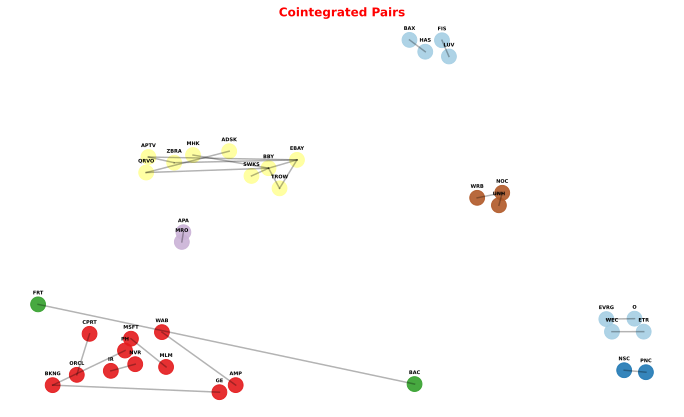

In [75]:
visualize_top_pairs(EG_pairs, in_EG_pairs_summary)

In [76]:
def pair_movements(ticker1, ticker2) :
    """
    Arguments :
    - close_df : DataFrame of daily closing prices 
    - ticker1 : str for the first ticker in the pair
    - ticker2 : str for the second ticker in the pair 
    
    Returns :
    - None 
    
    Function :
    - Draws a line plot of normalized closing prices for each ticker 
    """
    norm_close_pair = close[[ticker1, ticker2]].div(close[[ticker1, ticker2]].iloc[0]).mul(100)
    norm_close_pair.plot(figsize = (12, 5), fontsize = 10)
    
    plt.xlabel(xlabel = "")
    plt.ylabel(ylabel = "Normalized Close ($)", fontsize = 12)
    plt.show( )

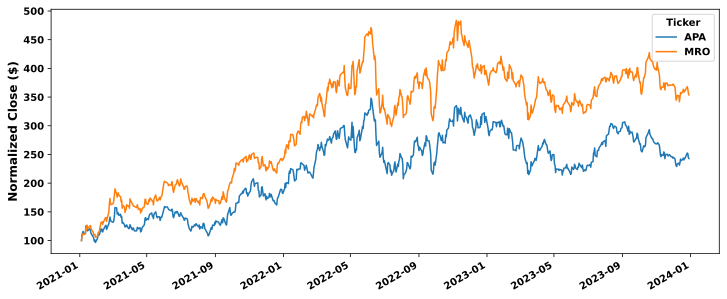

In [77]:
pair_movements("APA", "MRO")  

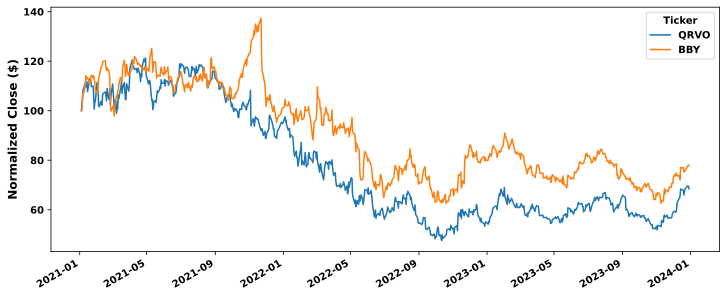

In [78]:
pair_movements("QRVO", "BBY") 

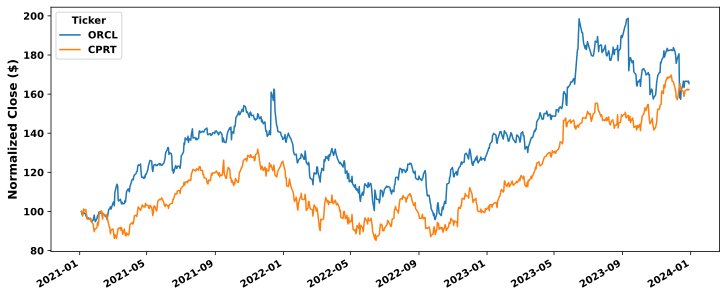

In [79]:
pair_movements("ORCL", "CPRT") 

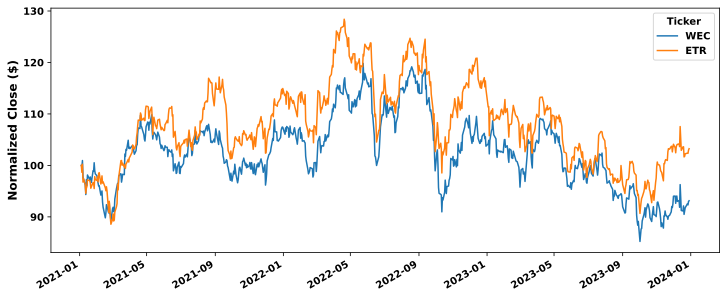

In [80]:
pair_movements("WEC", "ETR") 

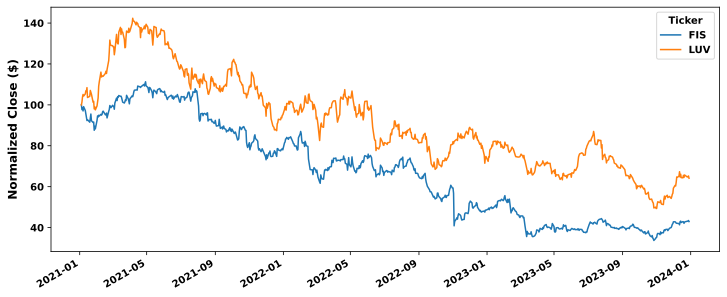

In [81]:
pair_movements("FIS", "LUV") 

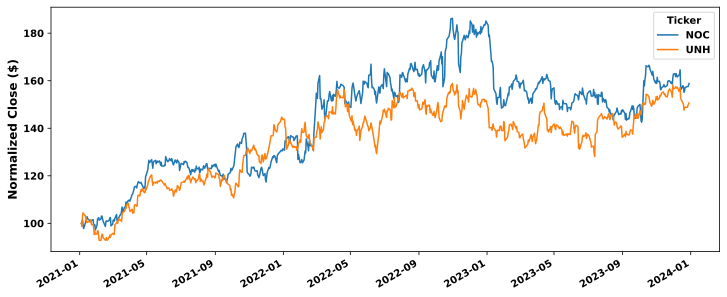

In [82]:
pair_movements("NOC", "UNH") 

## 12. Pairs Selection : Augmented Dickey Fuller Test
<a id="section-12"></a>

$$ \Delta y_t = \rho y_{t-1} + \gamma t + \alpha + \beta_1 \Delta y_{t-1} + \beta_2 \Delta y_{t-2} + \ldots + \beta_p \Delta y_{t-p} + \varepsilon_t $$

$\text{Where :}$
- $ \Delta \text{ represents the differencing operator.} $
- $ y_t \text{ is the level of the time series at time \(t\)}. $
- $ \rho \text{ is the coefficient on the lagged level of the time series.} $
- $ \gamma \text{ is the coefficient on the trend term.} $
- $ t \text{ is time.} $
- $ \alpha \text{ is a constant.} $
- $ \beta_1, \beta_2, \ldots, \beta_p \text{ are coefficients on the lagged differences of the time series up to order p.} $
- $ \varepsilon_t \text{ is the error term.} $

### 12.1 Cointegrated Pairs  
<a id="subsection-121"></a>

In [83]:
def ADF_clt_pairs(clt_close_df, significance = 0.01) : 
    """
    Arguments :
    - clt_close_df : DataFrame of closing prices of tickers in the cluster 
    - significance : float representing the significance level -> 0.01 or 0.05 or 0.1   

    Returns :
    - clt_pairs_df : DataFrame displaying the cointegrated pairs, cointegration p-values, and correlation coefficients  
    
    Function :
    - Conducts the Augmented Dickey Fuller cointegration test between all possible pairs in the cluster 
    - Selects pairs with cointegration p-value lower than the specified significance level 
    - Computes the correlation between tickers in each cointegrated pair 
    """
    n_tickers = clt_close_df.shape[1]
    tickers = clt_close_df.columns
    
    clt_pairs = [  ]
    pairs_pvals = [  ]
    pairs_corr = [  ]
    for i in range(n_tickers - 1) :
        
        for j in range(i + 1, n_tickers) :
            ticker1_close = clt_close_df[ tickers[i] ].values
            ticker2_close = clt_close_df[ tickers[j] ].values
            
            result = linear_model.OLS(ticker1_close, ticker2_close).fit( )
            c_t = stattools.adfuller(result.resid)
            t_stat = c_t[0]
            pvalue = c_t[1]
            crit_vals = c_t[4]
            
            if t_stat <= crit_vals["1%"] and pvalue <= significance :
                clt_pairs.append((tickers[i], tickers[j]))
                pairs_pvals.append(pvalue)
                pairs_corr.append(close[tickers[i]].corr(close[tickers[j]]))
    
    clt_pairs_df = pd.DataFrame(clt_pairs, columns = ["Ticker1", "Ticker2"])
    clt_pairs_df["Cointegration P_Value"] = pairs_pvals
    clt_pairs_df["Correlation"] = pairs_corr 
    
    industry_mapper = dict(zip(sp500_constituents["Symbol"], sp500_constituents["GICS Sector"]))
    clt_pairs_df["Ticker1 Industry"] = clt_pairs_df["Ticker1"].map(industry_mapper)
    clt_pairs_df["Ticker2 Industry"] = clt_pairs_df["Ticker2"].map(industry_mapper)
    
    return clt_pairs_df 

In [84]:
ADF_pairs = top_pairs(ap_clt_labels, ADF_clt_pairs)

Number of pairs found : 26
In those pairs, there are 43 unique tickers


In [85]:
ADF_pairs.round(4) 

,Ticker1,Ticker1 Industry,Ticker2,Ticker2 Industry,Cointegration P_Value,Correlation
Cluster,,,,,,
12,CPRT,Industrials,ORCL,Information Technology,0.0002,0.9435
22,APTV,Consumer Discretionary,EBAY,Consumer Discretionary,0.0002,0.9400
4,EVRG,Utilities,O,Real Estate,0.0004,0.9150
12,MLM,Materials,MSFT,Information Technology,0.0008,0.9001
12,BKNG,Consumer Discretionary,PH,Industrials,0.0008,0.9202
24,NOC,Industrials,WRB,Financials,0.0009,0.9175
12,AMP,Financials,WAB,Industrials,0.0012,0.9251
12,IR,Industrials,NVR,Consumer Discretionary,0.0012,0.9076
24,BSX,Health Care,LIN,Materials,0.0016,0.9046


In [86]:
in_ADF_pairs_summary = tickers_in_pairs(ADF_pairs, ap_clt_labels)

In [87]:
in_ADF_pairs_summary.round(4)

,Cluster,Annual Return,Annual Volatility,Annual Sharpe
Ticker,,,,
AEE,4,-0.8646,-1.1375,-0.9633
AMP,12,1.2311,-0.0693,1.3861
APA,18,2.6241,2.7795,1.2418
APTV,22,-1.1704,1.2765,-1.1884
BBY,22,-0.9596,0.7505,-1.0292
BKNG,12,0.8245,0.5467,0.6644
BSX,24,0.6084,-0.7793,1.0841
CBOE,1,1.0617,-0.7882,1.7205
CPRT,12,0.5706,-0.3165,0.7647


In [88]:
## Industry count in pairs
## Avg Return, Volatility, and Sharpe in each cluster 

### 12.2 Pairs Visualization 
<a id="subsection-122"></a>

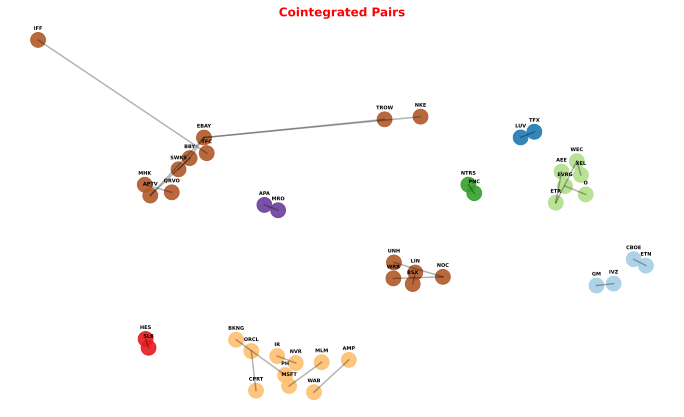

In [89]:
visualize_top_pairs(ADF_pairs, in_ADF_pairs_summary)

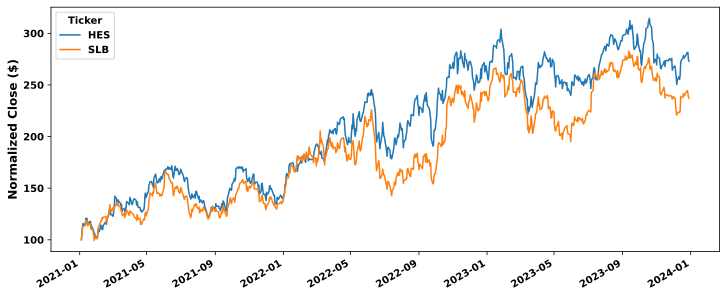

In [90]:
pair_movements("HES", "SLB") 

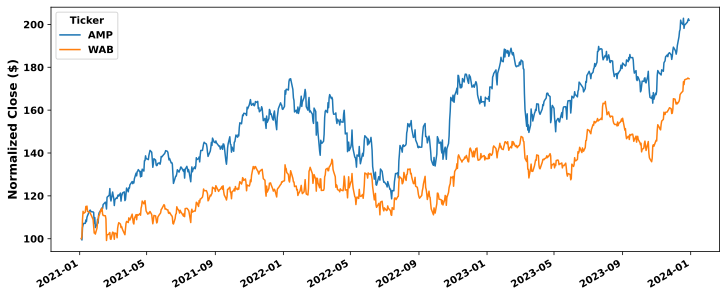

In [91]:
pair_movements("AMP", "WAB") 

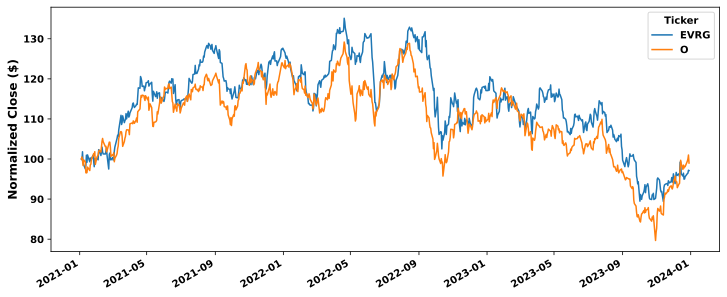

In [92]:
pair_movements("EVRG", "O") 

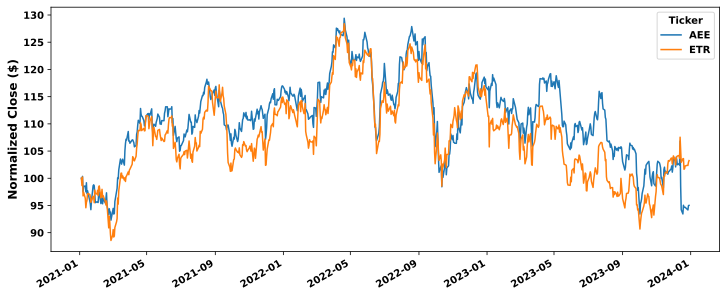

In [93]:
pair_movements("AEE", "ETR") 

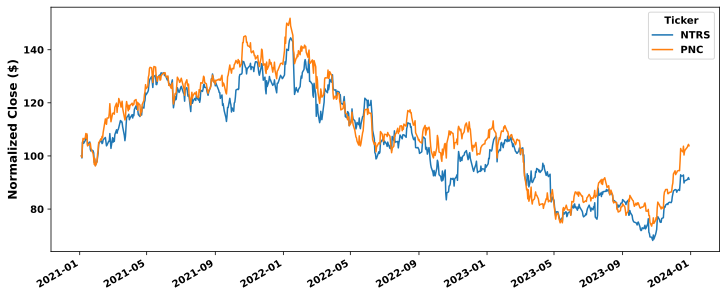

In [94]:
pair_movements("NTRS", "PNC") 

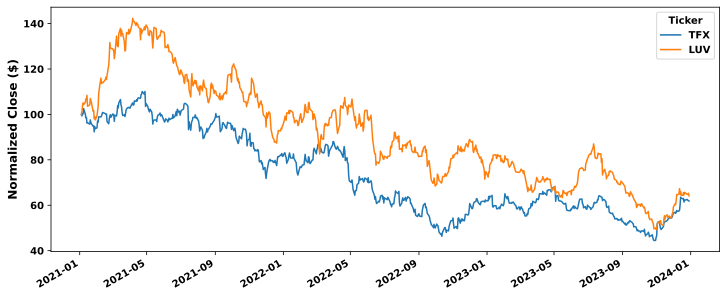

In [95]:
pair_movements("TFX", "LUV") 

## 13. Pairs Trading
<a id="section-13"></a>

In [96]:
def plot_bollinger_bands(pair, window = 42) :
    """
    Arguments :
    - pair : tuple containing the tickers of a pair 
    
    Returns :
    - None 
    
    Function :
    - Plots the spread between the pair 
    - Plots the middle bollinger band, which is the moving average of the spread 
    - Plots the upper bollinger band
    - Plots the lower bollinger band 
    """
    ticker1, ticker2 = pair 
    pair_close = close[[ticker1, ticker2]].copy( )
    
    pair_close["Hedge Ratio"] = pair_close[ticker1].div(pair_close[ticker2]).rolling(42).mean( ) 
    pair_close["Pair Spread"] = pair_close[ticker1].sub(pair_close[ticker2] * pair_close["Hedge Ratio"])
                                                              
    pair_close["Middle Band"] = pair_close["Pair Spread"].rolling(window).mean( ) 
    pair_close["Lower Band"] = pair_close["Middle Band"] - pair_close["Pair Spread"].rolling(window).std( ) * 2 
    pair_close["Upper Band"]  =  pair_close["Middle Band"] + pair_close["Pair Spread"].rolling(window).std( ) * 2
    
    fig , ax = plt.subplots(figsize = (12 , 15), sharex = False, sharey = False, nrows = 3, ncols = 1)
    colors = ["black", "tab:blue", "tab:red", "tab:green"]
    
    for i, year in enumerate(np.unique(close.index.year)) :
        for j, indicator in enumerate(["Pair Spread", "Middle Band", "Lower Band", "Upper Band"]) :
            
            ax[i].plot(pair_close.loc[str(year), indicator], c = colors[j], label = indicator)
            ax[i].set_xlabel("")
            ax[i].legend( )
    
    plt.show( )

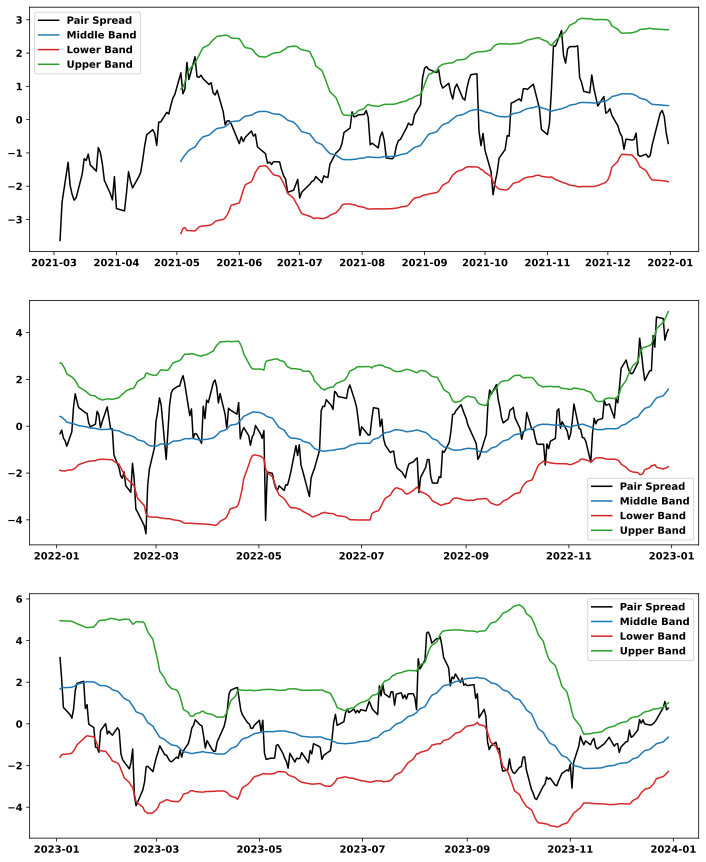

In [97]:
plot_bollinger_bands(("APA", "MRO"))

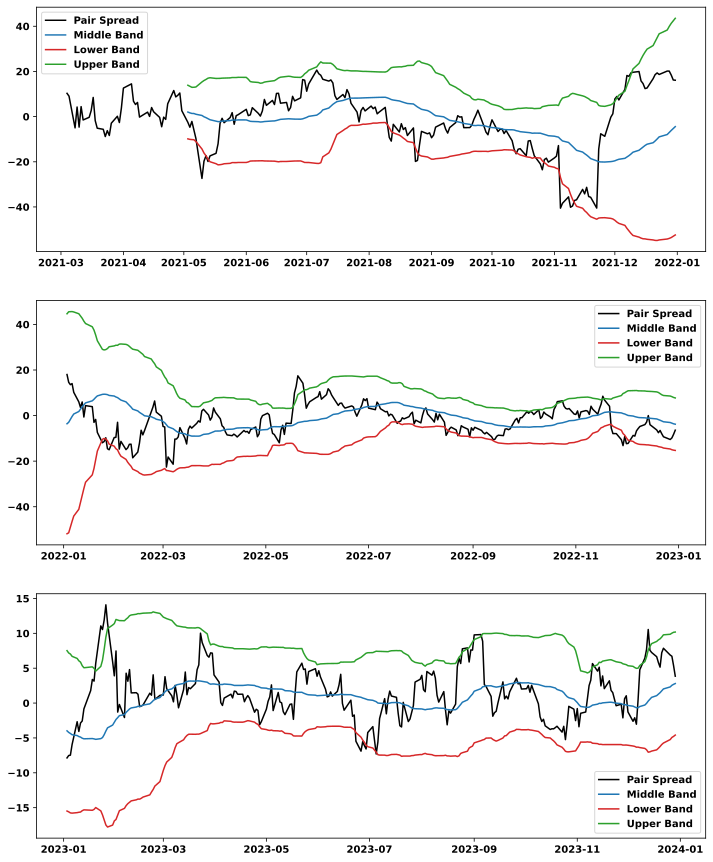

In [98]:
plot_bollinger_bands(("QRVO", "BBY"))

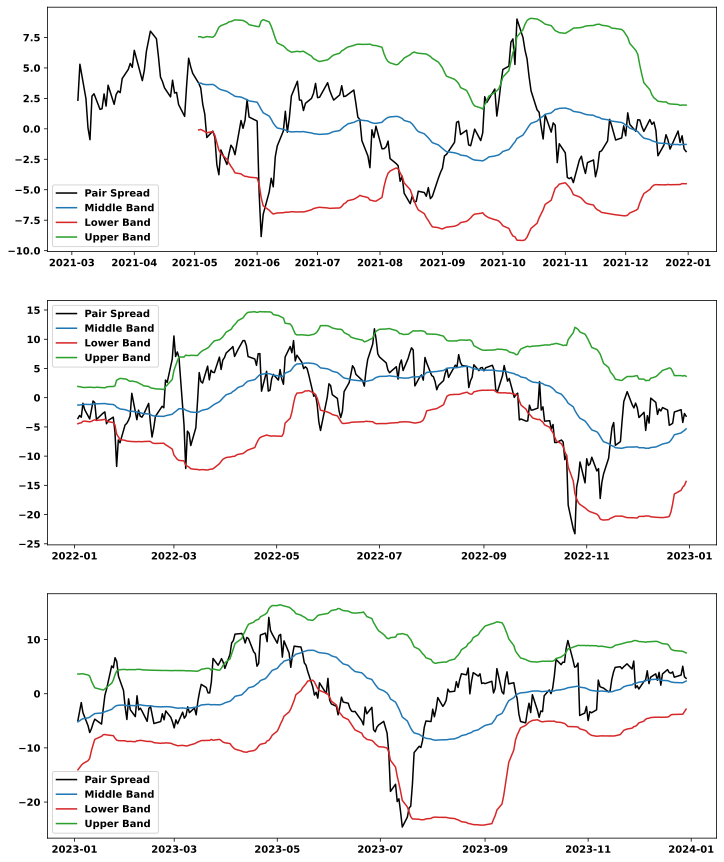

In [99]:
plot_bollinger_bands(("HES", "SLB"))

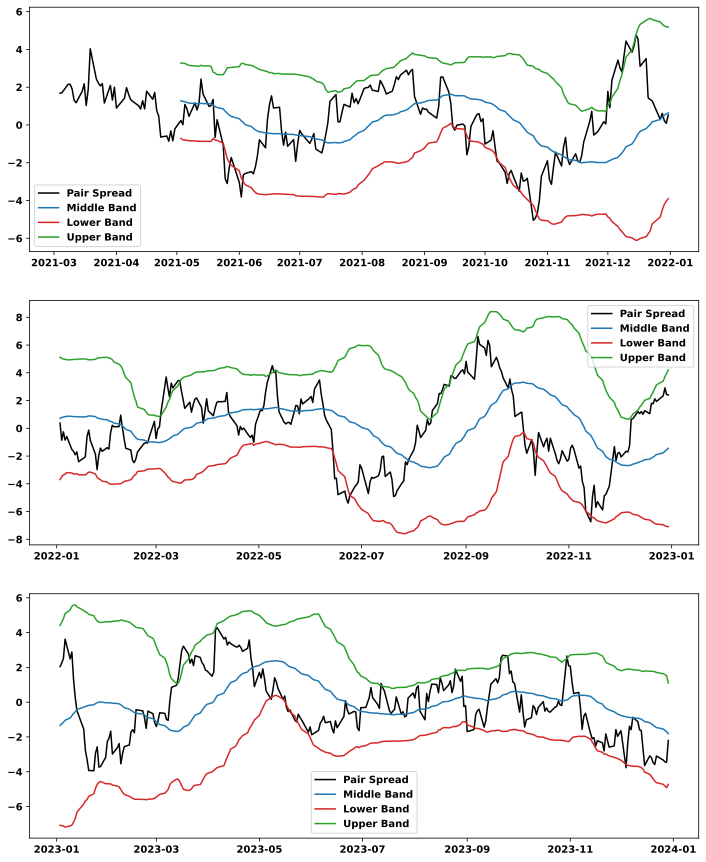

In [100]:
plot_bollinger_bands(("EVRG", "O"))

# Author 
[Khai Lap Vuong](https://www.linkedin.com/in/khai-lap-vuong/)